##### First we must import our csv and store it in a way that can be read by the computer. In this case we are using python's pandas library to store and use our data.We will also be using numpy and seaborn libraries as well 

## Imports

In [15]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn import model_selection

data = pd.read_csv('Attributes_DataFrame.csv')
df = pd.DataFrame(data)
df.head()

,Title,Domestic,International,Budget,Distributor,MPAA-Rating,Runtime,Genres
0,Jurassic World (2015),652270625,1018130012,150000000.0,Universal Pictures,PG-13,124,Action;Adventure;Sci-Fi
1,Star Wars: Episode VII - The Force Awakens (2015),936662225,1131561399,245000000.0,Walt Disney Studios Motion Pictures,PG-13,138,Action;Adventure;Sci-Fi
2,Avengers: Age of Ultron (2015),459005868,943800000,250000000.0,Walt Disney Studios Motion Pictures,PG-13,141,Action;Adventure;Sci-Fi
3,Inside Out (2015),356461711,501149463,175000000.0,Walt Disney Studios Motion Pictures,PG,95,Adventure;Animation;Comedy;Drama;Family;Fantasy
4,Furious 7 (2015),353007020,1162040651,190000000.0,Universal Pictures,PG-13,137,Action;Adventure;Thriller


##### Our data consists of 3400 movies which have 8 features, Title, Domestic and International Revenue, Budget, Distributor, Rating, Runtime, and Genres.

## Exploring relationship between budget and revenue

##### Our first conjecture is that movies with higher budgets will have highr revenues. To explore this, we must first make a total revenue category that will be the sum of domestic and international revenues. Then we can plot this category and budget on a scatter plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Budget', ylabel='Total Rev'>

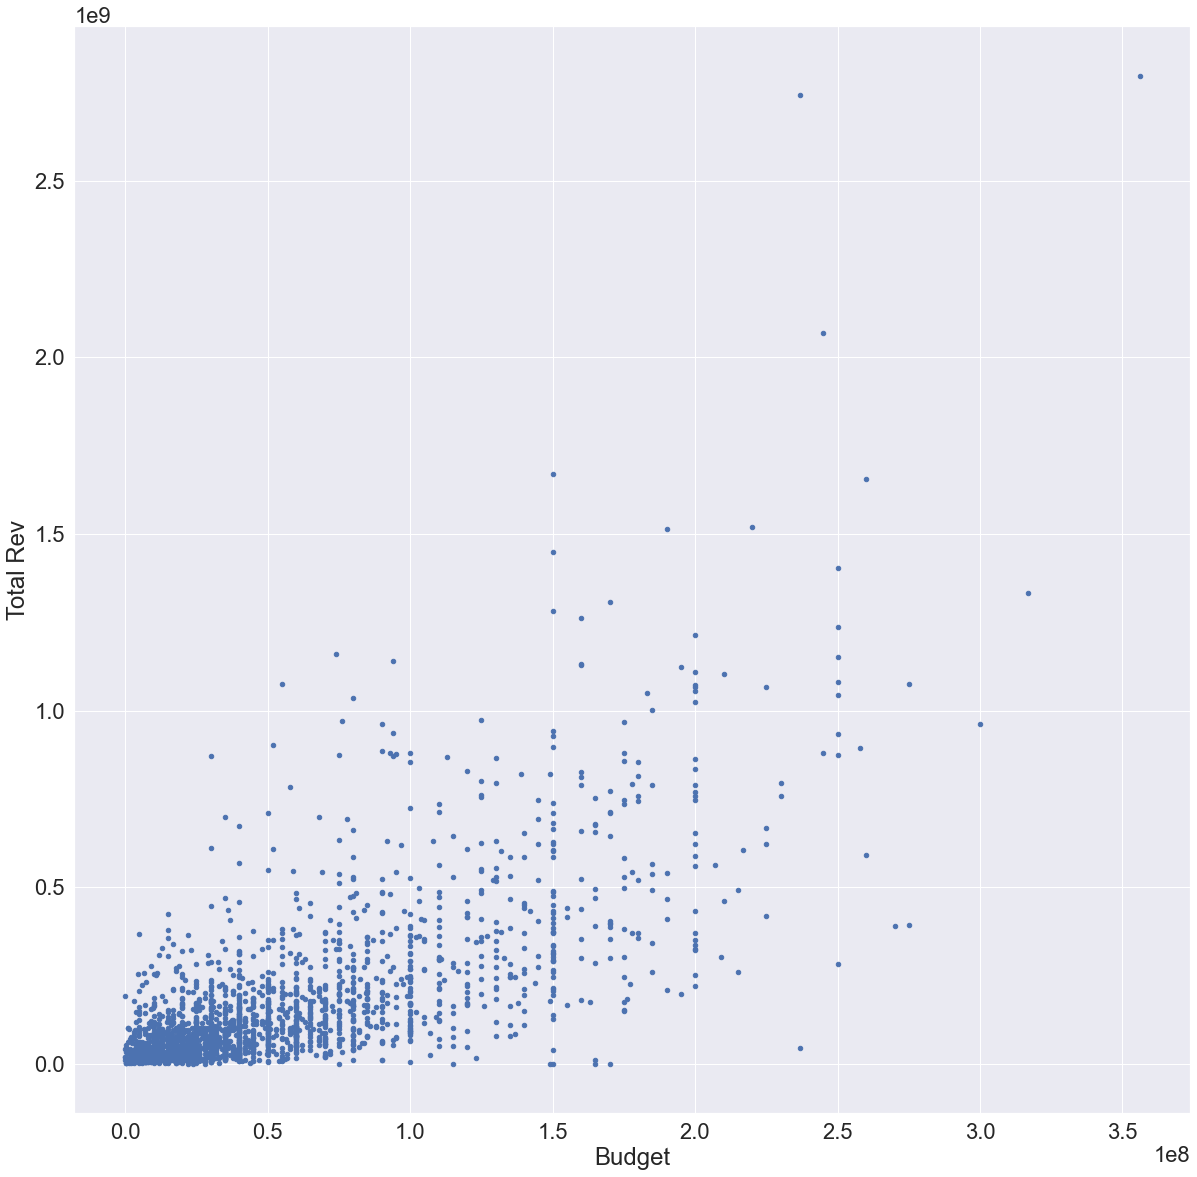

In [16]:
df['Total Rev']=df[['Domestic','International']].sum(axis = 1)
df.plot.scatter(x='Budget', y='Total Rev')

##### From our conjectures the first seems to be a general trend but we will explore this further.We can run a linear regression using Total Revenue and Budget but first we need to clean the data.This means that for movies whose budget or revenue are missing or 0 we will exclude them from the data we run the regression on. Once this is done we can us the SciKitLearn Package to run a linear regression

array([[1.        , 0.71662721],
       [0.71662721, 1.        ]])

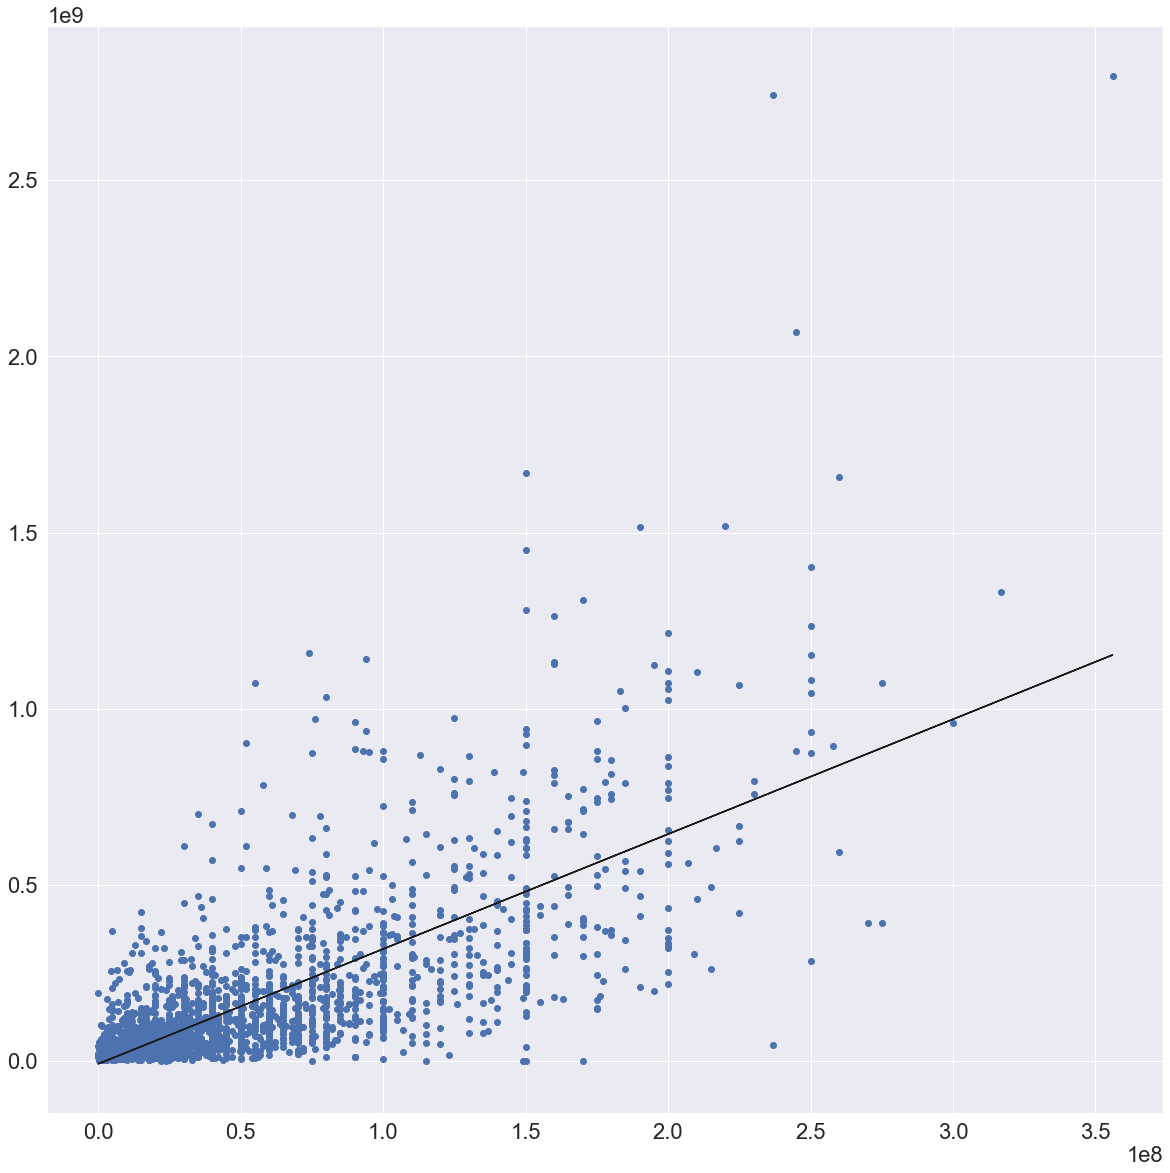

In [17]:
#Linear Regression of data including cleaning 
#cleaning
missing_values = ['na', 0, 'N/A', 'NA', 'n/a', 'None', 'none', None]
linregdata = pd.read_csv('Attributes_DataFrame.csv', na_values = missing_values)
dflr = pd.DataFrame(linregdata)
dflr.dropna(axis = 0, inplace = True)

#creating total rev
dflr['Total Rev']=dflr[['Domestic','International']].sum(axis = 1)

#regression
X = np.array(dflr[['Budget']])
y = np.array(dflr[['Total Rev']])
reg = LinearRegression()
reg.fit(X, y)

#plotting regression
plt.scatter(X, y)
plt.plot(X, reg.predict(X), color = 'k')

#correlation
np.corrcoef(np.transpose(X), np.transpose(y))

##### From our linear regression and correlation coefficient we can see that there is a somewhat strong positive correlation. However, we would like to see how well this model can predict revenue for a movie given its budget, outside of the data set. To do this we will run another linear regression but use training and testing data. We will again use Sci Kit Learn packages to separate our training and test data, and test our new linear regression

In [18]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state = 12)

linreg = LinearRegression().fit(X_train, y_train)
linreg.score(X_test, y_test)

0.6087915195977087

##### Our model received a low score and this was somewhat expected as the correlation between all the data was low. We now want to see if other features could improve this model, one such feature we are interested in is Genres. We will use the Seaborn package to graph another scatter plot but this time use a legend and colors to specify genre. As you may have noticed the Genres attribute has multiple genres for many movies this we will take a movies primary genre which will be the first one listed for the individual movie, and we will stoe it in a new column under "Primary Genre"

Text(0, 0.5, 'Total Rev')

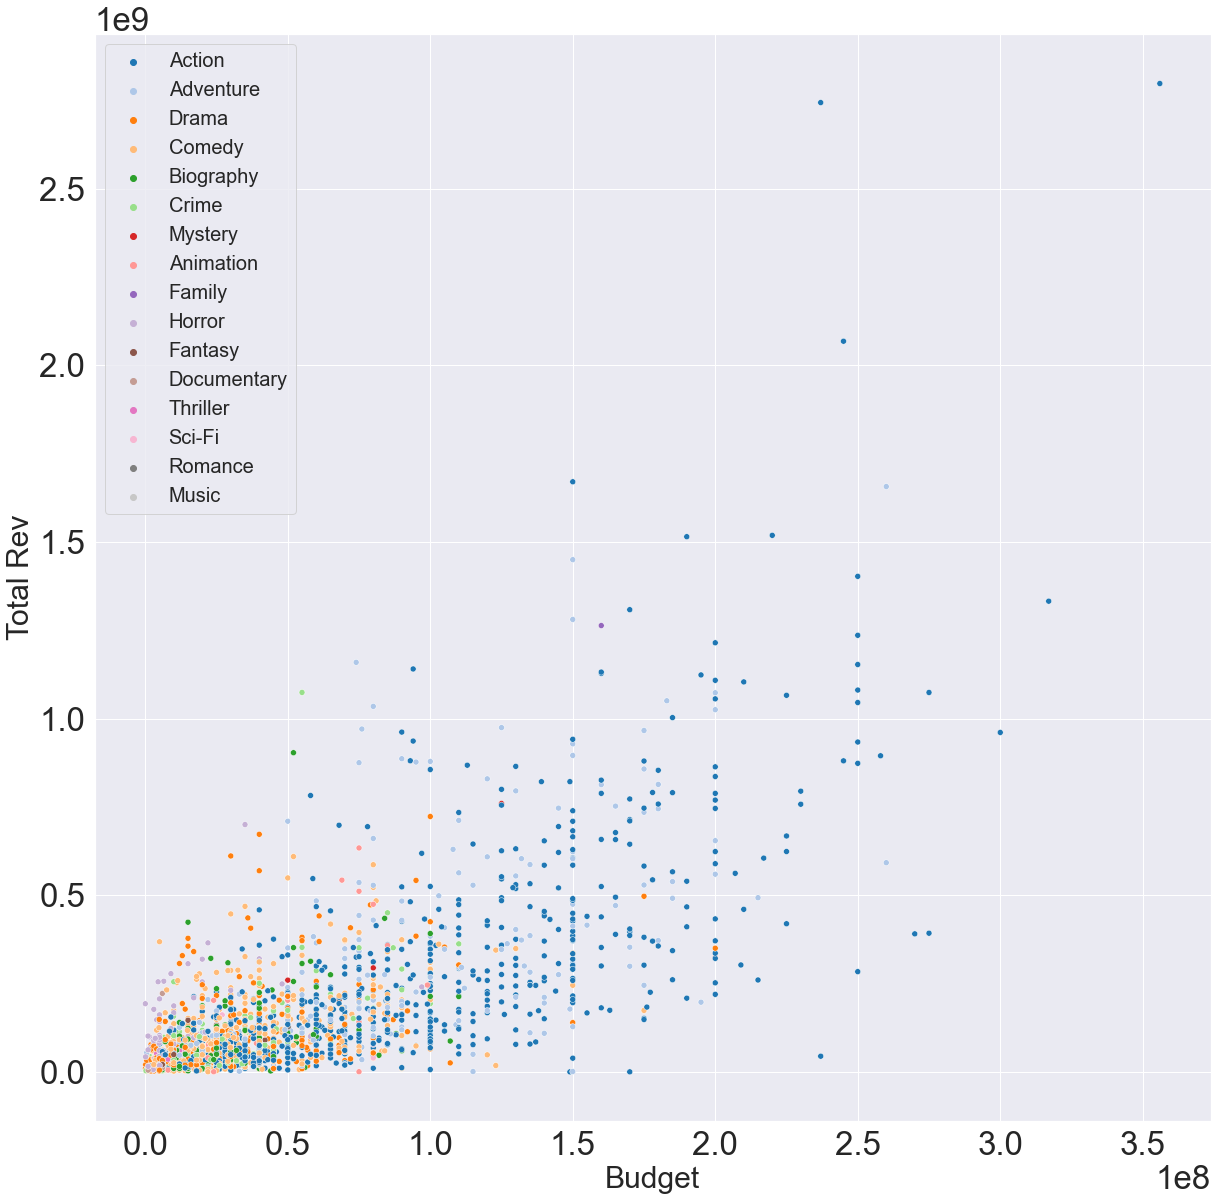

In [19]:
#Exploring Budget and Total Revenue with Genre

dflr['Primary Genre'] = dflr.Genres.str.split(';').str[0]

sb.set(rc={"figure.figsize":(20,20)})
sb.set(font_scale = 3)
plot = sb.scatterplot(x='Budget', y='Total Rev', data = dflr, hue = 'Primary Genre', palette = "tab20")
plt.legend(fontsize = 20)
plt.xlabel("Budget", fontsize = 30)
plt.ylabel("Total Rev", fontsize = 30)

##### From this last plot we can see how the action and adventure genres seem too have the highest revenues, but have high budgets as well. We will now see if using genres can strenghten our prediction model. To do this we will us pandas dummy variables wchich allow a categorical feature like genre to take on a binary value (0,1) for each genre. This would create a lot of new variables as each genre will be a new movie attribute. So to avoid over fitting and an overly complex model we will just consider the dummy variables for action and adventure. This will be stored under new columns 'Action Bin', and "Adventure Bin". Then we will again split the data into training and test data and run a multi linear regression using scikitlearn linear regression with movie budget, action dummy and adventure dummy being our X values while total revenue is still our y value

In [20]:
#multi linear regression, x = budget, dummy variables for Action and Adventure genre, y = total rev

dummydf = pd.get_dummies(dflr[['Primary Genre']])
dummydf
dflr['Action Bin']=dummydf[['Primary Genre_Action']]
dflr['Adventure Bin']=dummydf[['Primary Genre_Adventure']]

X_mlr = dflr[['Budget', 'Action Bin', 'Adventure Bin']]
y_mlr = dflr[['Total Rev']]

X_mlrtrain,X_mlrtest,y_mlrtrain,y_mlrtest = model_selection.train_test_split(X_mlr, y_mlr, test_size=0.1, random_state = 12)

mlinreg = LinearRegression().fit(X_mlrtrain, y_mlrtrain)
print(mlinreg.score(X_mlrtest, y_mlrtest), mlinreg.coef_)

0.606799708995301 [[ 3.23239677e+00 -2.44742975e+07  2.23060557e+07]]


##### Our model again had a weak score showing that perhaps this data is not linear. However one thing we can look at is the model coefficients which suggest that higher budgets correspond to higher revenue. Another interesting insight is that the coefficient for Action genre was negative. This suggests that a movie in the. Action genre is expected to make less money than a movie in the adventure genre which has the same budget

## Exploring relationship between rating and revenue

##### Another conjecture we had was that the MPAA-Rating of a movie would affect how much revenue that movie would make. To investigate this conjecture, we created boxplots for each rating (G, PG, PG-13, R, NR, and NC-17) to see where the middle 50% of movies in each rating in terms of revenue match up.

PG-13        1403
R            1241
PG            551
G              46
Not Rated       2
NC-17           1
Name: MPAA-Rating, dtype: int64

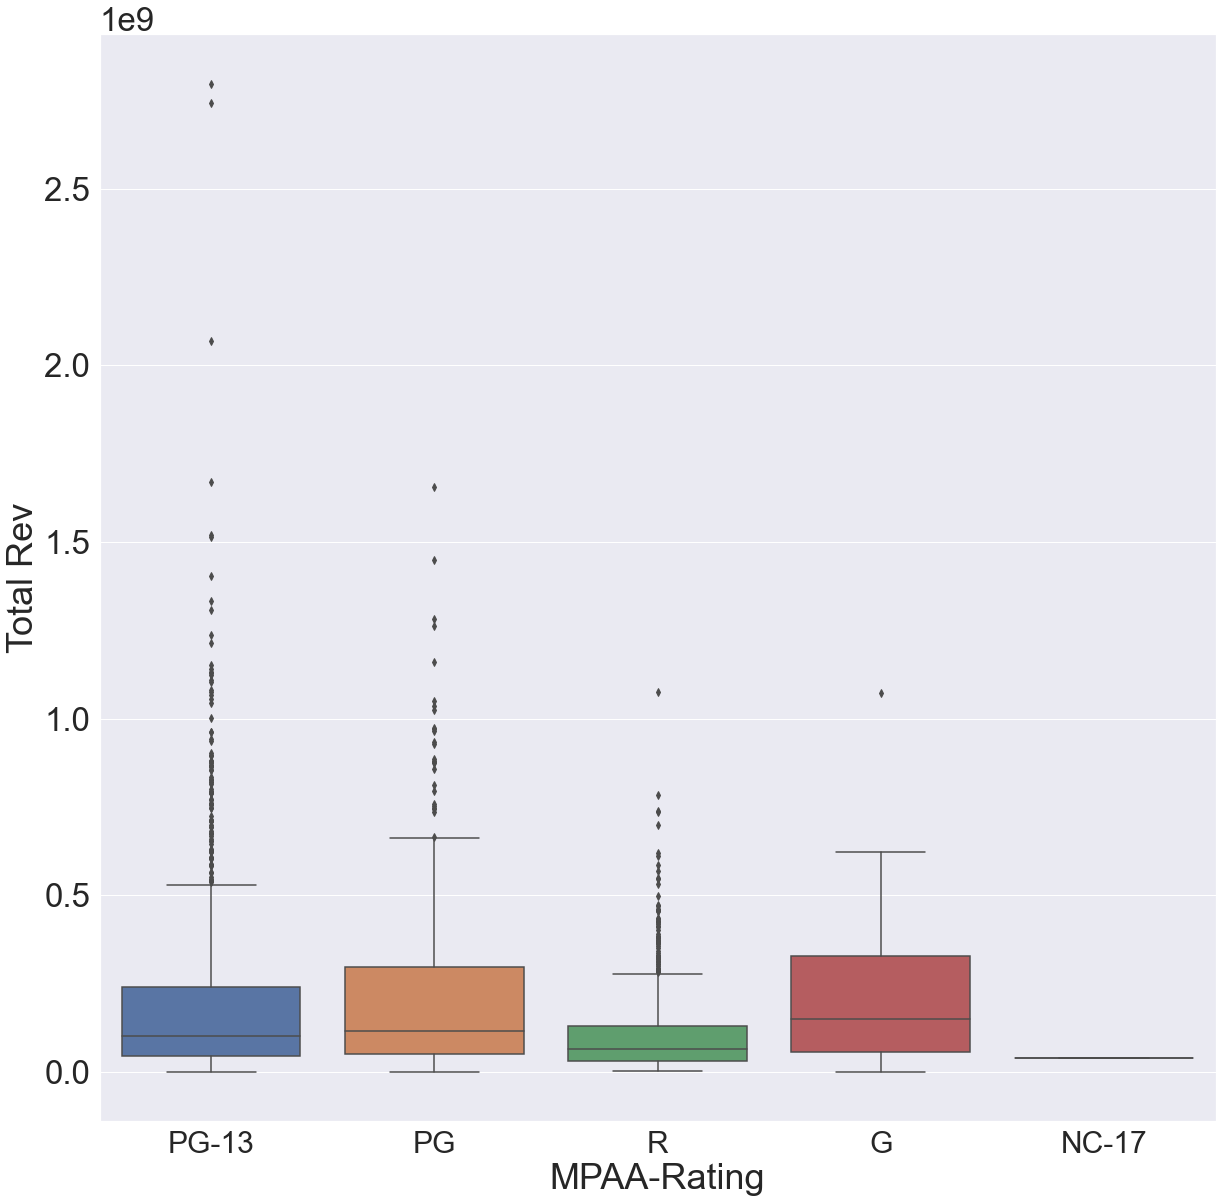

In [21]:
boxplot = sb.boxplot(x='MPAA-Rating', y = 'Total Rev', data = dflr)
boxplot.set_xticklabels(boxplot.get_xmajorticklabels(), fontsize = 30)

df['MPAA-Rating'].value_counts()

#####  In the dataset, there are 1403 PG-13 movies, but only 46 G rated movies. On average, G movies had higher revenue than PG-13 movies, but because there are so many more PG-13 movies, there are a considerable amount of PG-13 movies that made more revenue than the average of G-rated movies. To avoid this issue, we created a second boxplot (removing the NR and NC-17 ratings because there were only 2 and 1 movies in the data set respectively) of only the top 40 movies of each rating. 


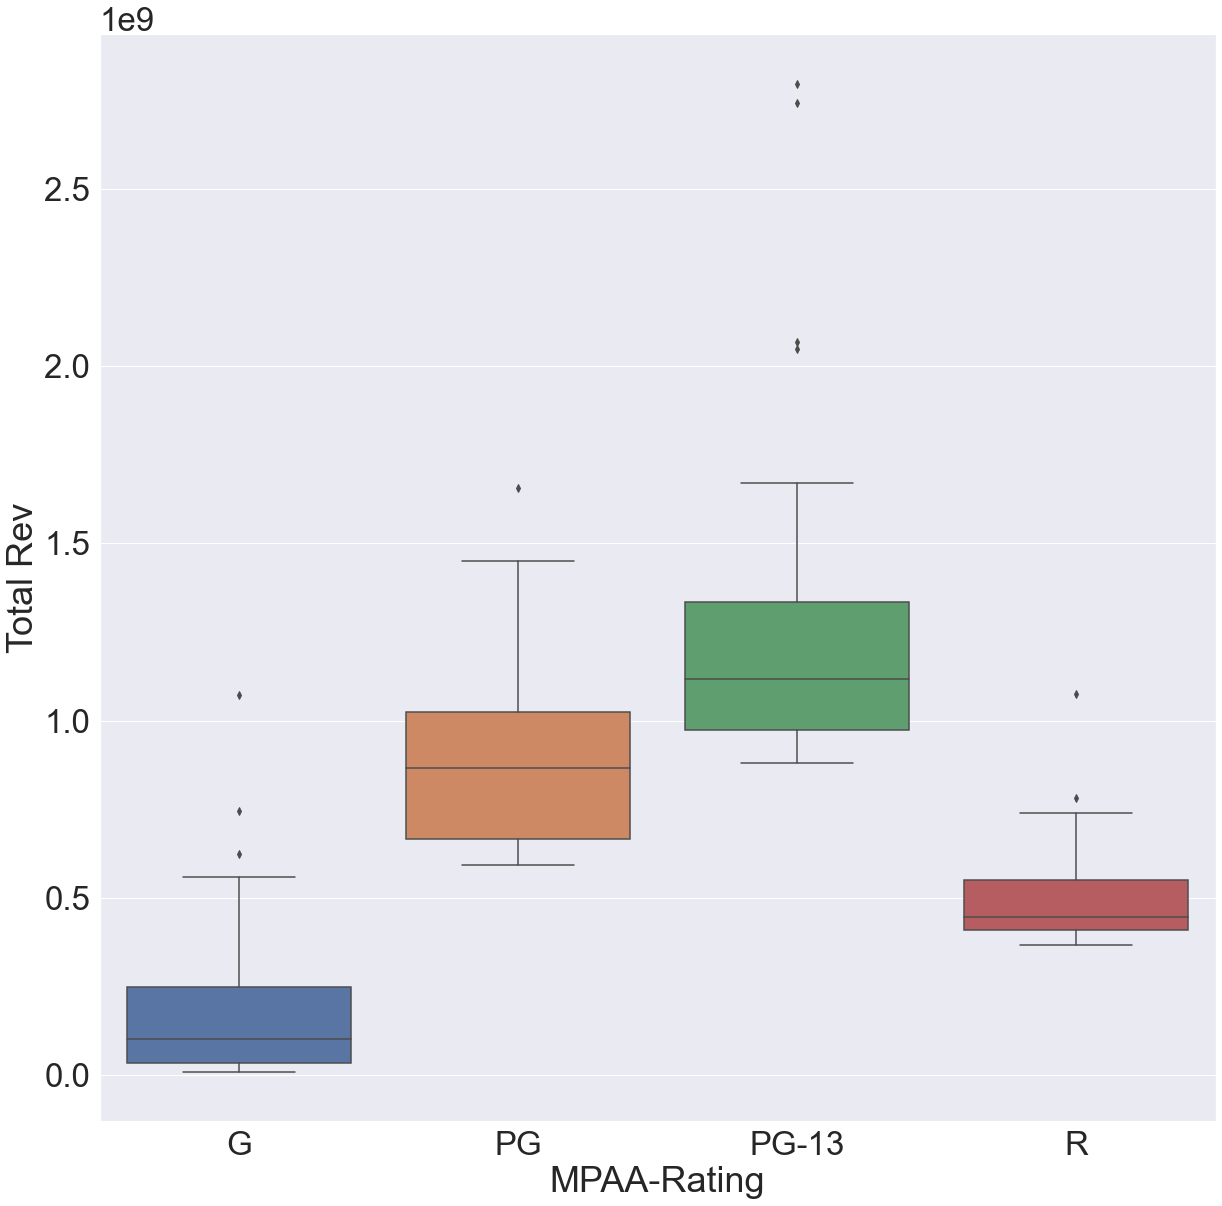

In [22]:
#Top 40 of each rating boxplot

df2 = df[['Total Rev', 'MPAA-Rating']].copy()

#G
G_df = df2[df['MPAA-Rating'] == 'G']

GSD = G_df["Total Rev"].std()
GMean = G_df["Total Rev"].mean()

G_df = G_df.nlargest(40, 'Total Rev')

#PG
PG_df = df2[df['MPAA-Rating'] == 'PG']

PGSD = PG_df["Total Rev"].std()
PGMean = PG_df["Total Rev"].mean()

PG_df = PG_df.nlargest(40, 'Total Rev')
dfnew = G_df.append([PG_df])

#PG-13
PG13_df = df2[df['MPAA-Rating'] == 'PG-13']

PG13SD = PG13_df["Total Rev"].std()
PG13Mean = PG13_df["Total Rev"].mean()

PG13_df = PG13_df.nlargest(40, 'Total Rev')
dfnew = dfnew.append([PG13_df])

#R
R_df = df2[df['MPAA-Rating'] == 'R']

RSD = R_df["Total Rev"].std()
RMean = R_df["Total Rev"].mean()

R_df = R_df.nlargest(40, 'Total Rev')
dfnew = dfnew.append([R_df])

boxplot = sb.boxplot(x='MPAA-Rating', y = 'Total Rev', data = dfnew)

##### With only the most popular movies of each rating being accounted for, popular PG-13 movies make the most revenue.

##### Finally, we wanted to see the overall spread of revenue for each main rating, so we found the mean and standard deviation of each rating.

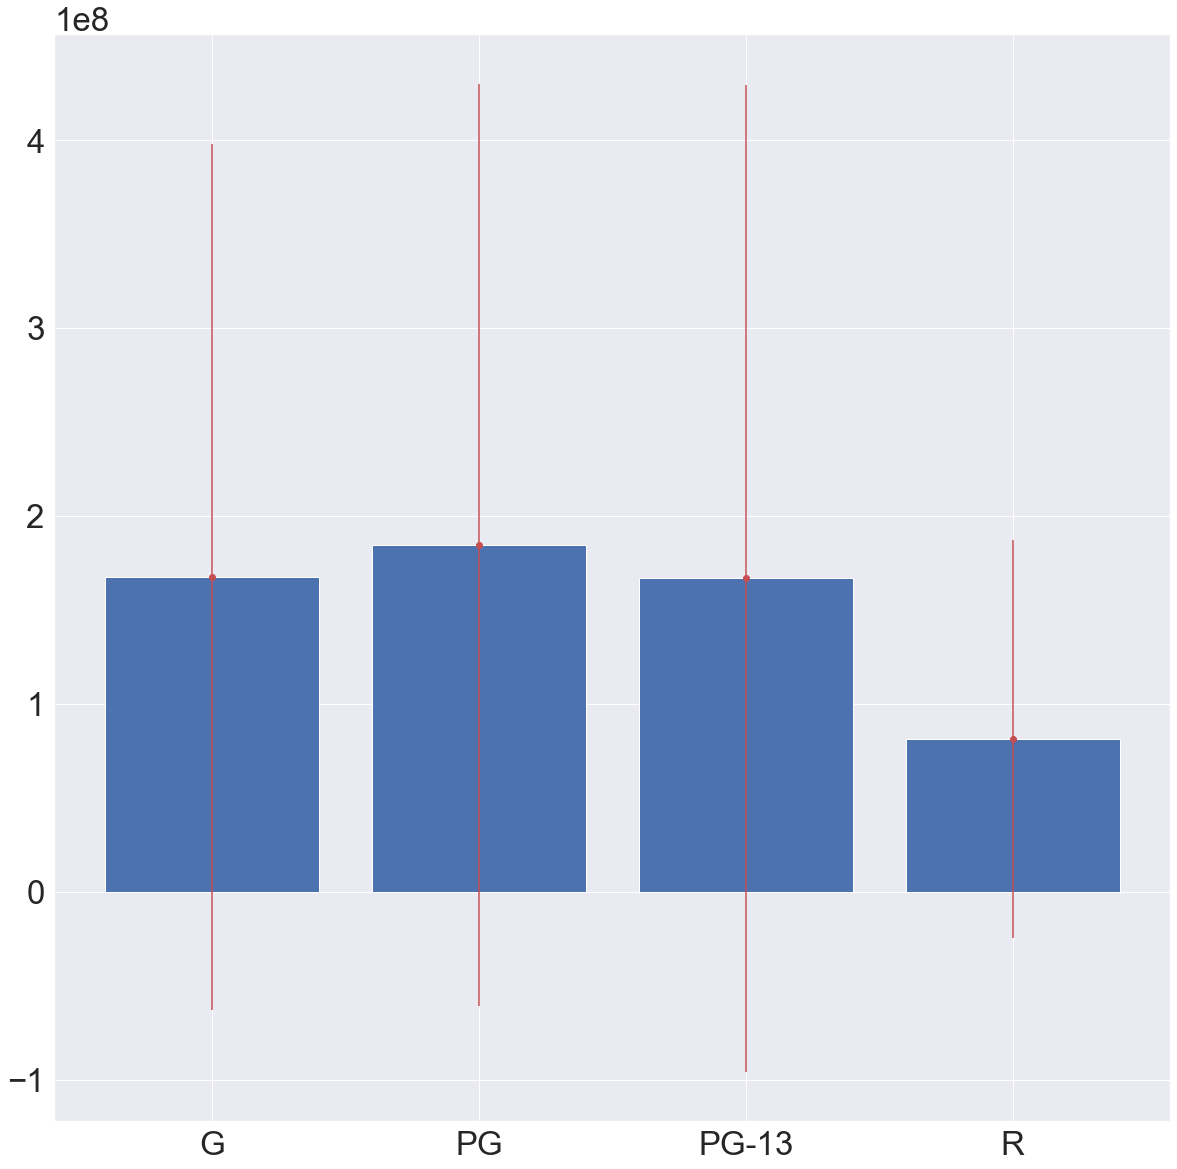

In [23]:
#Mean and SD of each rating


# making a simple plot
a = ['G', 'PG', 'PG-13', 'R']
b = [GMean, PGMean, PG13Mean, RMean]
  
# Plot scatter here
plt.bar(a, b)

c = [GSD, PGSD, PG13SD, RSD]
  
plt.errorbar(a, b, yerr=c, fmt="o", color="r")
  
plt.show()

##### For R rated movies, there is not much variation in terms of revenue. A high-grossing R rated movie will tend to make around the same revenue. The other three ratings have high standard deviations, meaning it is hard to predict how much revenue a movie will make based just on its rating alone.

## Exploring relationship between distributor and revenue

In [24]:
# counts number of occurance of a movie distributos
df_distributor  = df['Distributor'].value_counts()
print(df_distributor)

Warner Bros.                           397
Universal Pictures                     328
Twentieth Century Fox                  292
Walt Disney Studios Motion Pictures    275
Sony Pictures Entertainment (SPE)      230
                                      ... 
Mirror/LD Entertainment                  1
8x Entertainment                         1
Cohen Media Group                        1
Mulberry Square                          1
Capelight Pictures                       1
Name: Distributor, Length: 149, dtype: int64


##### Since there are 149 different movie studios with many only producing one movie, we only used the top 10 movie distributors with the largest number of movies produced. This ensures there is stastical significance with the data we are analyzing.

In [25]:
# finds top 10 movie distributors
df_top_10_distributors = df_distributor.head(10)
df_top_10_distributors

Warner Bros.                           397
Universal Pictures                     328
Twentieth Century Fox                  292
Walt Disney Studios Motion Pictures    275
Sony Pictures Entertainment (SPE)      230
Lionsgate                              225
Paramount Pictures                     224
Fox Searchlight Pictures               110
Focus Features                         103
New Line Cinema                         73
Name: Distributor, dtype: int64

In [26]:
# List of top 10 movie distributors
list_of_dist = ['Warner Bros.', 'Universal Pictures', 'Twentieth Century Fox', 
                'Walt Disney Studios Motion Pictures', 'Sony Pictures Entertainment (SPE)',
               'Lionsgate', 'Paramount Pictures','Fox Searchlight Pictures', 'Focus Features',
               'New Line Cinema']

##### Using these distributors, we combined the other fields to form the new dataset. Also, this dataset calculates revenue in a similar way to the previous conjectures.

In [27]:
#gathering data of distributors in list
df_other = df[df['Distributor'].isin(list_of_dist)]
df_other2 = df_other[['Title', 'Domestic', 'International', 'Budget','Distributor', 'MPAA-Rating', 'Runtime','Genres']]
df_other2['Total Rev of Top 10']=df_other2[['Domestic','International']].sum(axis = 1)
df_other2

,Title,Domestic,International,Budget,Distributor,MPAA-Rating,Runtime,Genres,Total Rev of Top 10
0,Jurassic World (2015),652270625,1018130012,150000000.0,Universal Pictures,PG-13,124,Action;Adventure;Sci-Fi,1670400637
1,Star Wars: Episode VII - The Force Awakens (2015),936662225,1131561399,245000000.0,Walt Disney Studios Motion Pictures,PG-13,138,Action;Adventure;Sci-Fi,2068223624
2,Avengers: Age of Ultron (2015),459005868,943800000,250000000.0,Walt Disney Studios Motion Pictures,PG-13,141,Action;Adventure;Sci-Fi,1402805868
3,Inside Out (2015),356461711,501149463,175000000.0,Walt Disney Studios Motion Pictures,PG,95,Adventure;Animation;Comedy;Drama;Family;Fantasy,857611174
4,Furious 7 (2015),353007020,1162040651,190000000.0,Universal Pictures,PG-13,137,Action;Adventure;Thriller,1515047671
...,...,...,...,...,...,...,...,...,...
3369,Buddy Games (2020),405904,447994,NaN,Paramount Pictures,R,90,Comedy,853898
3376,Die Hard (2020),325000,98221,28000000.0,Walt Disney Studios Motion Pictures,NaN,132,Action;Thriller,423221
3381,How the Grinch Stole Christmas (2020),420180,18035601,123000000.0,Universal Pictures,PG,104,Comedy;Family;Fantasy,18455781
3384,Wonder Woman (2020),252000,204493,149000000.0,Warner Bros.,PG-13,141,Action;Adventure;Fantasy;Sci-Fi;War,456493


##### Next we created a box plot to show the total revenue for each movie of each of the top 10 distributors

<AxesSubplot:title={'center':'Total Rev of Top 10'}, xlabel='Distributor'>

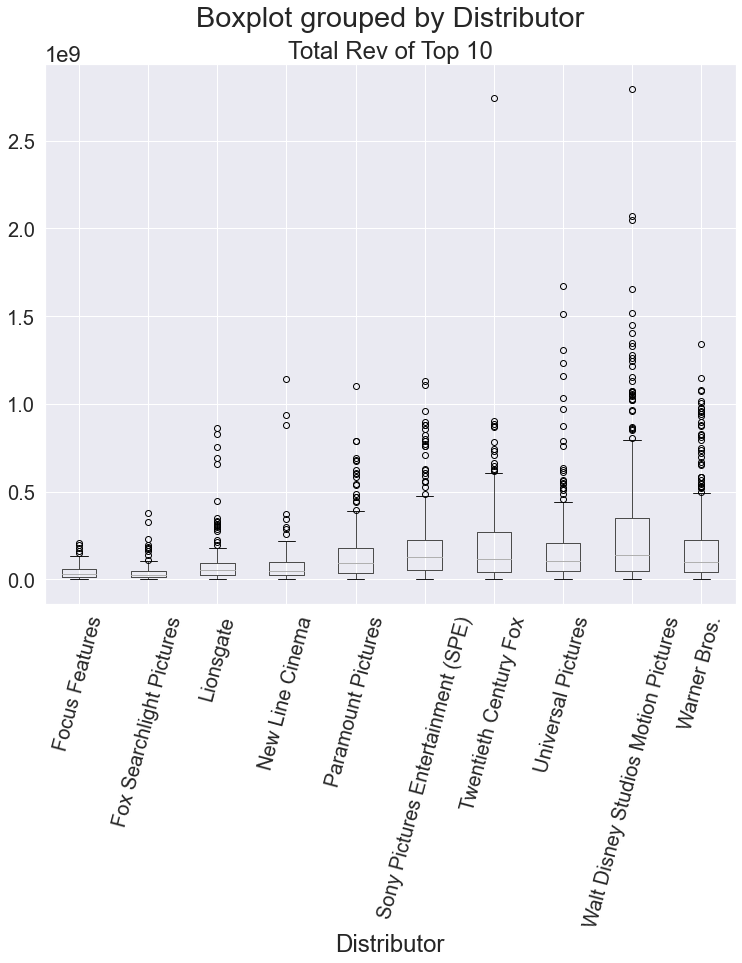

In [28]:
#creating box plot
sb.set(font_scale = 2)
df_other2.boxplot(by='Distributor', column = 'Total Rev of Top 10', rot=75, fontsize=20, grid='True', figsize=(12,10))

##### The team discovered that the median total revenue of the ten movies were all relatively close, meaning that the distributor did not have a significant impact when considering movies that were in the middle of the line. We do see higher third quartile and first quartile results for movies that were in the top half of the number of movies distributed.